<a href="https://colab.research.google.com/github/Icetiger1/python/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Анализ временных рядов

#Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
#
from keras.models import Sequential
from keras.layers import (Dense,
                          Conv1D,
                          Dropout,
                          Flatten,
                          BatchNormalization)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Загрузка данных

In [ ]:
!git clone https://github.com/Lasttrader/DA_repo

Cloning into 'DA_repo'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 63 (delta 1), reused 1 (delta 0), pack-reused 58
Receiving objects: 100% (63/63), 31.42 MiB | 10.04 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (24/24), done.


In [ ]:
path = '/content/DA_repo/Gazprom_stocks/02_03.csv'

In [ ]:
df = pd.read_csv(path, sep = ';')
df.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2002,11:00:00,373.00,374.5,373.00,374.50,5064
1,03.01.2002,11:01:00,374.50,375.4,374.01,374.01,8450
2,03.01.2002,11:02:00,374.12,375.2,374.10,374.65,507
3,03.01.2002,11:03:00,374.65,375.0,374.03,375.00,1669
4,03.01.2002,11:04:00,375.00,375.6,375.00,375.60,4000


In [ ]:
df = df.iloc[:150000, :]

In [ ]:
df.shape

(150000, 7)

#График

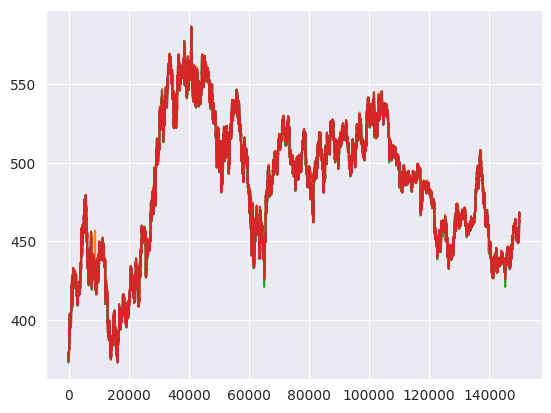

In [ ]:
channelNames = ['OPEN',	'MAX',	'MIN',	'CLOSE']

for i in range(len(channelNames)):
  plt.plot(df[channelNames[i]])
plt.show()

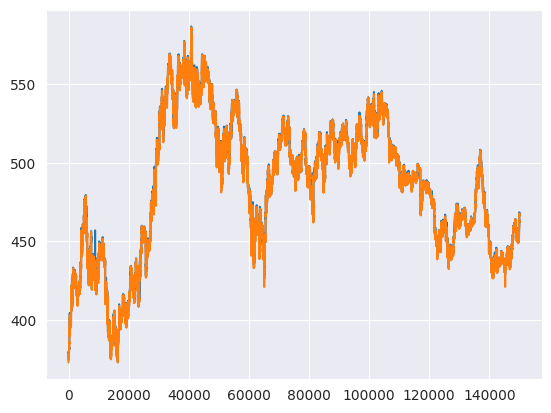

In [ ]:
channelNames = ['MAX',	'MIN']

for i in range(len(channelNames)):
  plt.plot(df[channelNames[i]])
plt.show()

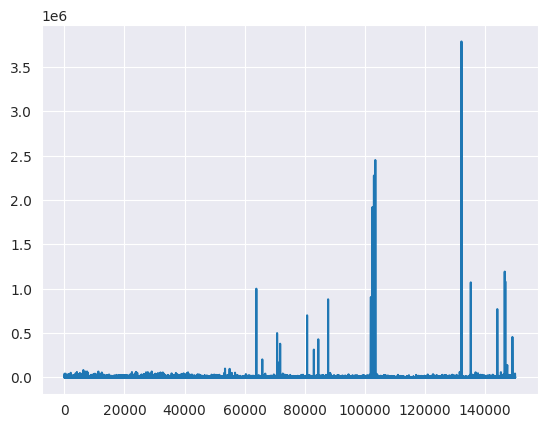

In [ ]:
plt.plot(df['VOLUME'])
plt.show()

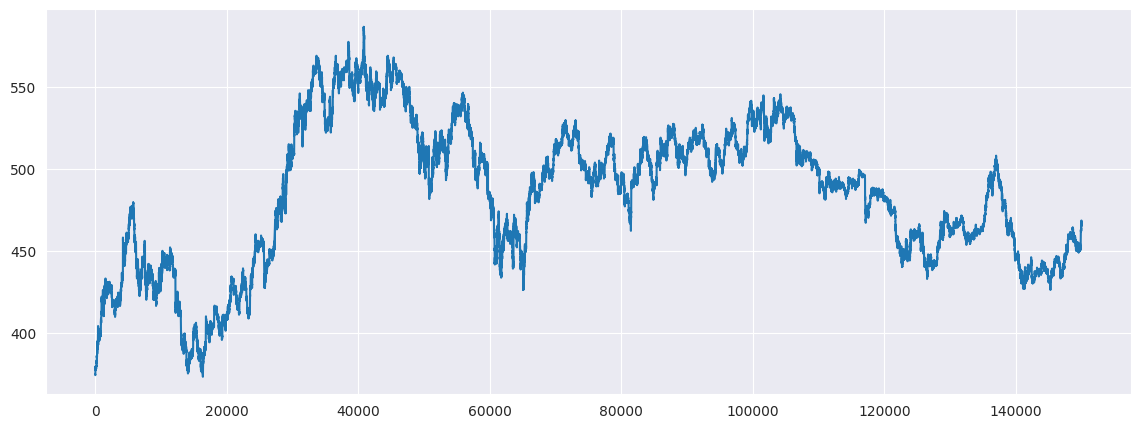

In [ ]:
plt.figure(figsize =(14,5))
plt.plot(df['CLOSE'])
plt.show()

#параметризация


In [ ]:
#Ищем цикличность
XY = pd.DataFrame() #временный пустой датафрейм

XY['log_model_CLOSE'] = np.log(df['CLOSE'])
XY['model_trend'] = np.arange(len(df['CLOSE']))

#Компонент Фурье (разложение временного ряда)
for i in range(1,11):
  wname_sin = "SIN%2d" % (i)
  XY[wname_sin] = np.sin(2 * np.pi * i * (XY['model_trend'] + 1) /12)
  wname_cos = "COS%2d" % (i)
  XY[wname_cos] = np.cos(2 * np.pi * i * (XY['model_trend'] + 1) /12)

In [ ]:
XY.head()

,log_model_CLOSE,model_trend,SIN 1,COS 1,SIN 2,COS 2,SIN 3,COS 3,SIN 4,COS 4,...,SIN 6,COS 6,SIN 7,COS 7,SIN 8,COS 8,SIN 9,COS 9,SIN10,COS10
0,5.925592,0,0.500000,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17,8.660254e-01,-0.5,...,1.224647e-16,-1.0,-0.500000,-8.660254e-01,-8.660254e-01,-0.5,-1.000000e+00,-1.836970e-16,-8.660254e-01,0.5
1,5.924283,1,0.866025,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00,-8.660254e-01,-0.5,...,-2.449294e-16,1.0,0.866025,5.000000e-01,8.660254e-01,-0.5,3.673940e-16,-1.000000e+00,-8.660254e-01,-0.5
2,5.925992,2,1.000000,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.0,...,3.673940e-16,-1.0,-1.000000,-4.286264e-16,-4.898587e-16,1.0,1.000000e+00,5.510911e-16,2.388680e-15,-1.0
3,5.926926,3,0.866025,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00,8.660254e-01,-0.5,...,-4.898587e-16,1.0,0.866025,-5.000000e-01,-8.660254e-01,-0.5,-7.347881e-16,1.000000e+00,8.660254e-01,-0.5
4,5.928525,4,0.500000,-8.660254e-01,-8.660254e-01,0.5,1.000000e+00,1.194340e-15,-8.660254e-01,-0.5,...,2.388680e-15,-1.0,-0.500000,8.660254e-01,8.660254e-01,-0.5,-1.000000e+00,8.578717e-16,8.660254e-01,0.5


<Axes: >

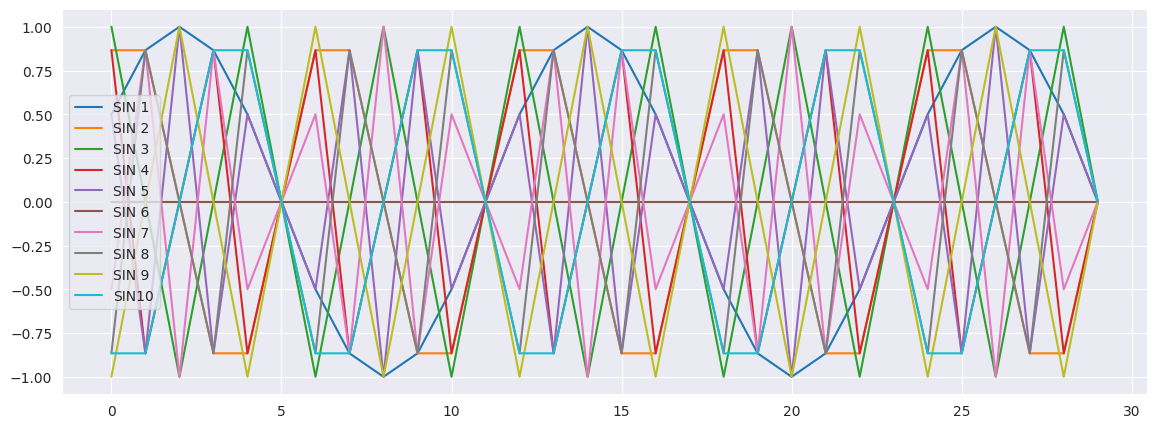

In [ ]:
XY.filter(like = 'SIN', axis =1).head(30).plot(figsize =(14,5))

#Функция подготовкаи временного ряда

In [ ]:
def get_from_TS(data, # датасет
                xLen, #отрезок временного ряда, для нейронки
                xChannels, #признаки X
                yChannels, #признаки y
                stepsForward, # на сколько шагов вперед
                xNormalization, #флаг нормализации Х
                yNormalization, #флаг нормализации y
                valLen, #длина тестового (валидационного) отрезка
                b, # отступ между х и у
                returnFlatten #признак выполнения выпрямления в вектор
                ):
  '''
  функция принимает на входе датасет с временным рядом
  и возвращает выборку train и test
  '''
  #выбираем тип нормализации
  #1- нормирвоание от 0-1
  #0- нормальное распределение
  if xNormalization == 0:
    xScaler = StandardScaler()
  else:
    xScaler = MinMaxScaler()
  #Выбираем каналы для трансформации (которые в Х)
  xData = data[:, xChannels]
  #обучение модели масштабирования
  xScaler.fit(xData)
  xData = xScaler.transform(xData)

  #выбираем тип нормализации для Y
  #1- нормирвоание от 0-1
  #0- нормальное распределение
  if yNormalization == 0:
    yScaler = StandardScaler()
  else:
    yScaler = MinMaxScaler()
  #Выбираем каналы для трансформации (которые в Х)
  yData = data[:, yChannels]
  #обучение модели масштабирования
  yScaler.fit(yData)
  yData = yScaler.transform(yData)

  ####TRAIN####
  #Формируем xTrain
  #нарезаем временной ряд на кусочки xLen с шагом 1
  xTrain = np.array([xData[i : i +xLen, xChannels]
                    for i in range(xData.shape[0] - xLen - 1 - stepsForward)])
  #Формируем Train
  # берем шаг прогноза stepsForward после xLen
  if stepsForward > 0:
    yTrain = np.array([yData[i + xLen  : i + xLen + stepsForward, yChannels]
                      for i in range(yData.shape[0] - xLen - 1 - stepsForward)])
  else:
    yTrain = np.array([yData[i + xLen + stepsForward, yChannels]
                      for i in range(yData.shape[0] - xLen - 1 - stepsForward)])
  # reshape в зависимости от того на сколько шагов stepsForward прогнозируем вперед
  if stepsForward == 0:
    if len(yChannels) == 1:
      yTrain = yTrain.reshape(yTrain.shape[0], 1)
  else:
    yTrain = yTrain.reshape(yTrain.shape[0], stepsForward)
  #делаем отступ между обучающей и проверочной выборкой
  xTrainLen  = xTrain.shape[0]
  bias = xLen + stepsForward + b
  #TEST (train_test_split)
  xTest = xTrain[xTrainLen - valLen :]
  yTest = yTrain[xTrainLen - valLen :]
  #оставшуюся часть используем для обучения
  xTrain = xTrain[: xTrainLen - valLen - bias]
  yTrain = yTrain[: xTrainLen - valLen - bias]
  # Если используем выпрямление (для слоёв Dense)
  if returnFlatten > 0:
    xTrain = np.array([x.flatten() for x in xTrain])
    xTest = np.array([x.flatten() for x in xTest])

  return (xTrain, yTrain), (xTest, yTest), (xScaler, yScaler)

#Подготовка датасета

In [ ]:
df_drop_date = df.drop(['DATE', 'TIME'],axis = 1)
df_drop_date.head()

,OPEN,MAX,MIN,CLOSE,VOLUME
0,373.00,374.5,373.00,374.50,5064
1,374.50,375.4,374.01,374.01,8450
2,374.12,375.2,374.10,374.65,507
3,374.65,375.0,374.03,375.00,1669
4,375.00,375.6,375.00,375.60,4000


#Config

In [ ]:
data_ = df_drop_date
xLen = 300 #отрезок которым идём по временному ряду
stepsForward = 0
xChannels = np.array(range(df_drop_date.shape[1])) #все признаки
yChannels = [0] #признаки y
xNormalization = 0  #флаг нормализации Х
yNormalization = 0 #флаг нормализации y
valLen = 50000 #длина тестового (валидационного) отрезка
b = 2 # отступ между х и у
returnFlatten = 1

In [ ]:
data_.shape

(150000, 5)

In [ ]:
df_drop_date.shape

(239332, 5)

##train_test_split

In [ ]:
(xTrain, yTrain), (xTest, yTest), (xScaler, yScaler) = get_from_TS(np.array(data_),
                                                                   xLen,
                                                                   xChannels,
                                                                   yChannels,
                                                                   stepsForward,
                                                                   xNormalization,
                                                                   yNormalization,
                                                                   valLen,
                                                                   b,
                                                                   returnFlatten)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(99397, 1500)
(99397, 1)
(50000, 1500)
(50000, 1)


In [ ]:
df_drop_date.head()

,OPEN,MAX,MIN,CLOSE,VOLUME
0,373.00,374.5,373.00,374.50,5064
1,374.50,375.4,374.01,374.01,8450
2,374.12,375.2,374.10,374.65,507
3,374.65,375.0,374.03,375.00,1669
4,375.00,375.6,375.00,375.60,4000


#Dense нейронная сеть

In [ ]:
model = Sequential()
model.add(Dense(300, input_dim = xTrain.shape[1], activation = 'relu'))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(75,  activation = 'relu'))
model.add(Dense(30,  activation = 'relu'))
#выходной слой
model.add(Dense(yTrain.shape[1],  activation = 'linear'))

model.compile(loss = 'mape',
              optimizer = 'adam')

history = model.fit(xTrain, yTrain,
                    epochs = 25,
                    batch_size = 50,
                    validation_data = (xTest, yTest),
                    verbose = 1)

pd.DataFrame(history.history).plot(figsize =(14,5))
plt.yLabel('Ошибка в %')
plt.show()

Epoch 1/25
1988/1988 [==============================] - 13s 6ms/step - loss: 6.1829 - val_loss: 9.9478
Epoch 2/25
1988/1988 [==============================] - 11s 5ms/step - loss: 2.1954 - val_loss: 7.8794
Epoch 3/25
1988/1988 [==============================] - 11s 5ms/step - loss: 1.7063 - val_loss: 7.6163
Epoch 4/25
1988/1988 [==============================] - 9s 5ms/step - loss: 1.4552 - val_loss: 3.8394
Epoch 5/25
1988/1988 [==============================] - 10s 5ms/step - loss: 1.3046 - val_loss: 3.2419
Epoch 6/25
1988/1988 [==============================] - 15s 8ms/step - loss: 1.2113 - val_loss: 3.3231
Epoch 7/25
1988/1988 [==============================] - 15s 8ms/step - loss: 1.1084 - val_loss: 2.3994
Epoch 8/25
1988/1988 [==============================] - 16s 8ms/step - loss: 1.0093 - val_loss: 2.6577
Epoch 9/25
1988/1988 [==============================] - 15s 7ms/step - loss: 1.0043 - val_loss: 1.8742
Epoch 10/25
1988/1988 [==============================] - 10s 5ms/step - lo

KeyError: ignored

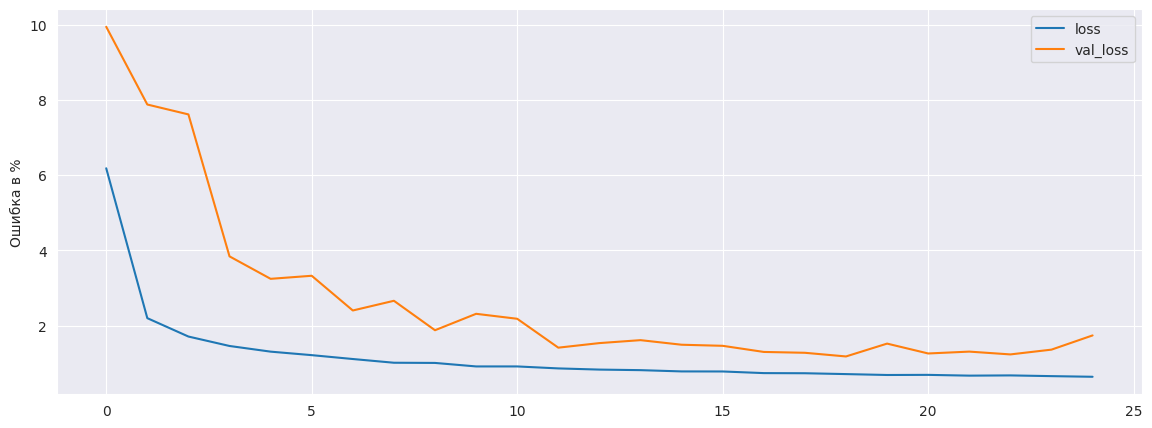

In [ ]:
pd.DataFrame(history.history).plot(figsize =(14,5))
plt.ylabel('Ошибка в %')
plt.show()

#Conv1D нейронная сеть

In [ ]:
data_ = df_drop_date
xLen = 300 #отрезок которым идём по временному ряду
stepsForward = 0
xChannels = np.array(range(df_drop_date.shape[1])) #все признаки
yChannels = [0] #признаки y
xNormalization = 0  #флаг нормализации Х
yNormalization = 0 #флаг нормализации y
valLen = 50000 #длина тестового (валидационного) отрезка
b = 2 # отступ между х и у
returnFlatten = 0


(xTrain, yTrain), (xTest, yTest), (xScaler, yScaler) = get_from_TS(np.array(data_),
                                                                   xLen,
                                                                   xChannels,
                                                                   yChannels,
                                                                   stepsForward,
                                                                   xNormalization,
                                                                   yNormalization,
                                                                   valLen,
                                                                   b,
                                                                   returnFlatten)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(99397, 300, 5)
(99397, 1)
(50000, 300, 5)
(50000, 1)


In [ ]:
xTrain[:1]

array([[[-2.58652188, -2.55481309, -2.58340415, -2.5517507 ,
          0.20951438],
        [-2.55181103, -2.53398394, -2.56003526, -2.56308959,
          0.41689579],
        [-2.56060444, -2.53861264, -2.55795288, -2.54827961,
         -0.06958694],
        ...,
        [-2.15842137, -2.14980197, -2.15536016, -2.14679033,
          0.06068484],
        [-2.14685109, -2.14100744, -2.14471691, -2.14216221,
          0.31087771],
        [-2.14222297, -2.12665848, -2.14379141, -2.12364974,
          0.33035417]]])

In [ ]:
xTrain.shape[1]

300

In [ ]:
xTrain.shape[2]

5

Epoch 1/20
994/994 [==============================] - 21s 8ms/step - loss: 25.5017 - val_loss: 18.6964
Epoch 2/20
994/994 [==============================] - 7s 7ms/step - loss: 13.0239 - val_loss: 14.0634
Epoch 3/20
994/994 [==============================] - 9s 10ms/step - loss: 8.8980 - val_loss: 22.6545
Epoch 4/20
994/994 [==============================] - 9s 9ms/step - loss: 8.6369 - val_loss: 13.5153
Epoch 5/20
994/994 [==============================] - 9s 9ms/step - loss: 7.3317 - val_loss: 8.7588
Epoch 6/20
994/994 [==============================] - 9s 9ms/step - loss: 6.9532 - val_loss: 10.0858
Epoch 7/20
994/994 [==============================] - 10s 10ms/step - loss: 5.5397 - val_loss: 9.0180
Epoch 8/20
994/994 [==============================] - 8s 8ms/step - loss: 5.4485 - val_loss: 8.1683
Epoch 9/20
994/994 [==============================] - 10s 10ms/step - loss: 4.6488 - val_loss: 8.1887
Epoch 10/20
994/994 [==============================] - 9s 9ms/step - loss: 4.3455 - val

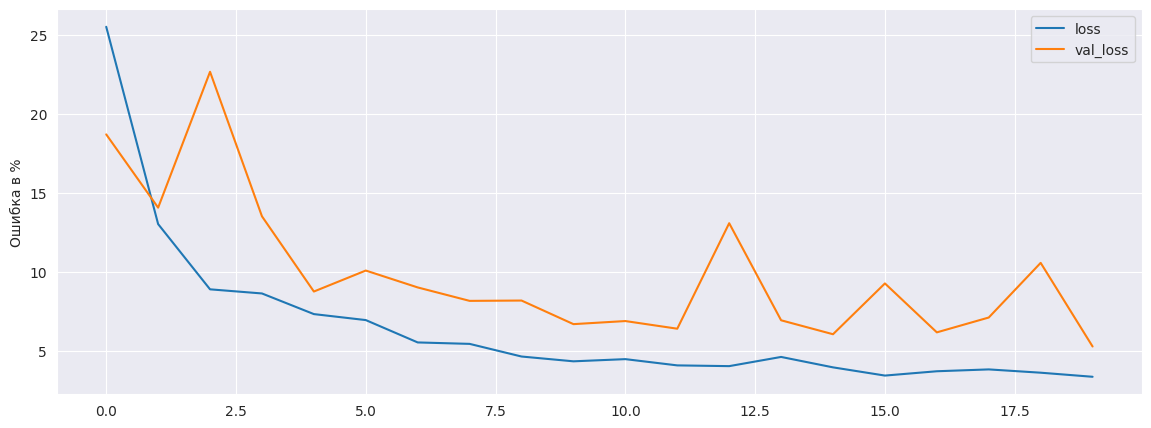

In [ ]:
model = Sequential()
model.add(Conv1D(100, 5, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation = 'relu'))
model.add(Flatten()) #даже после conv1D
model.add(Dense(150, activation = 'relu'))
model.add(Dense(75,  activation = 'relu'))
model.add(Dense(30,  activation = 'relu'))
#выходной слой
model.add(Dense(yTrain.shape[1],  activation = 'linear'))

model.compile(loss = 'mape',
              optimizer = 'adam')

history = model.fit(xTrain, yTrain,
                    epochs = 20,
                    batch_size = 100,
                    validation_data = (xTest, yTest),
                    verbose = 1)

pd.DataFrame(history.history).plot(figsize =(14,5))
plt.ylabel('Ошибка в %')
plt.show()

#Функция прогноза

In [ ]:
def get_predict(currentModel,
                xTest,
                yTest,
                yScaler):
  yPred = yScaler.inverse_transform(currentModel.predict(xTest))
  yTrue = yScaler.inverse_transform(yTest)
  # yPred = currentModel.predict(xTest)
  # yTrue = yTest

  return yPred, yTrue


#Визуализация результатов

In [ ]:
def get_visualization(start, #стартовая точка на графике (в датасете) откуда начнём прогноз
                      step, #длина графика
                      channel, #какой канал отрисовываем
                      yPred, #predict
                      yTrue #наш фактический у из тестовой выборки
                      ):
  plt.figure(figsize = (15, 5))
  plt.plot(yPred[start : start + step, channel],
           label = 'Прогнозные значения')
  plt.plot(yTrue[start : start + step, channel],
           label = 'Фактическое значение')
  plt.xlabel('время, индекс')
  plt.ylabel('значения')
  plt.legend()
  plt.show()


#График

In [ ]:
(yPred, yTrue) = get_predict(model,
                             xTest,
                             yTest,
                             yScaler)

1563/1563 [==============================] - 4s 2ms/step


In [ ]:
xTest[:3]

In [ ]:
yTest[:3]

array([[531.55],
       [531.55],
       [531.55]])

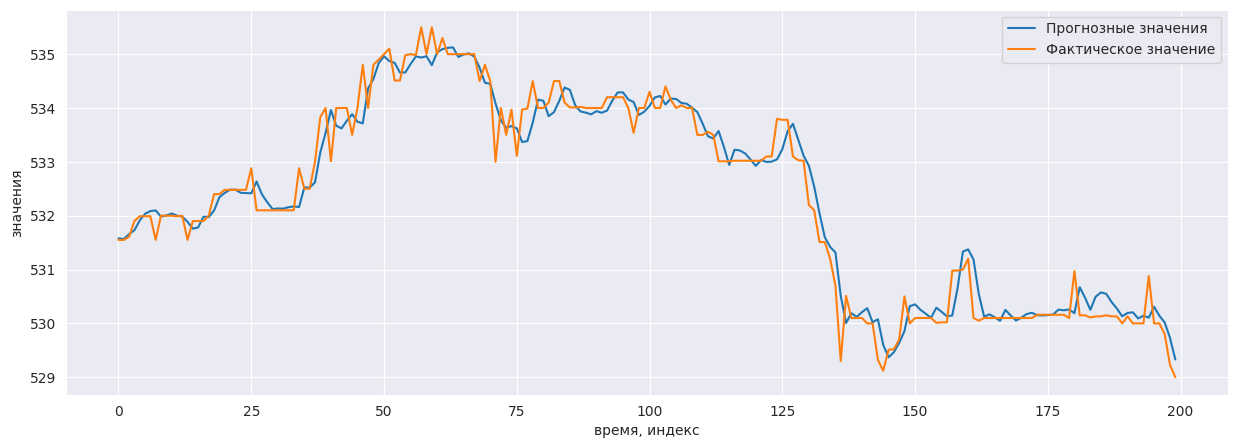

In [ ]:
get_visualization(1,200,0,yPred,yTrue)

#Функция рассчёта корреляции

In [ ]:
def get_corr(a,b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  val=0
  if (sa > 0) & (sb > 0):
    val = (mab-ma*mb) / (sa *sb)

  return val

In [ ]:
def show_corr(channels, #анализируемый канал временного ряда
              corrSteps, #кол-во шагов на которое смотрим назад, ля оценки корреляции
              yPred,
              yTrue
              ):
  for c in channels:
    corr = [] #пустой список для корреляции
    yLen = yTrue.shape[0]
    for i in range(corrSteps):
      corr.append(get_corr(yTrue[:yLen-i, c], yPred[i:, c])) #корреляциия для текущего corrSteps
    plt.plot(corr, label = f'Прогноз на {c + 1} шаг')
    plt.xlabel('кол-во шагов назад')
    plt.ylabel('значение корреляции')
    plt.legend()
    plt.show()


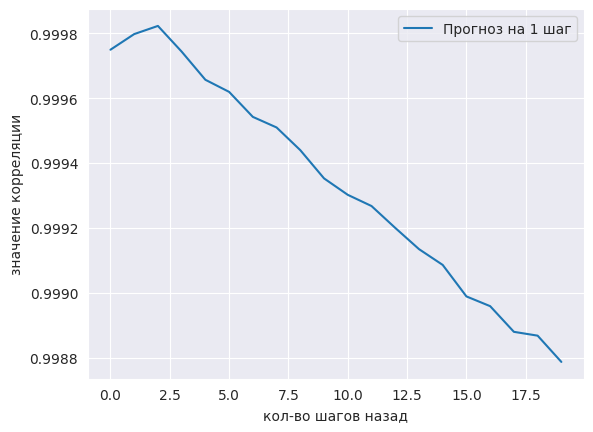

In [ ]:
show_corr([0], 20, yPred, yTrue)

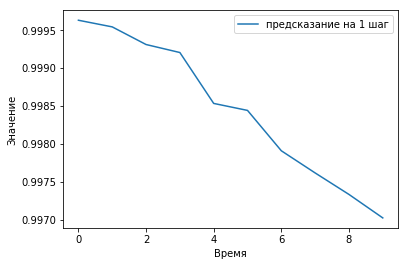

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

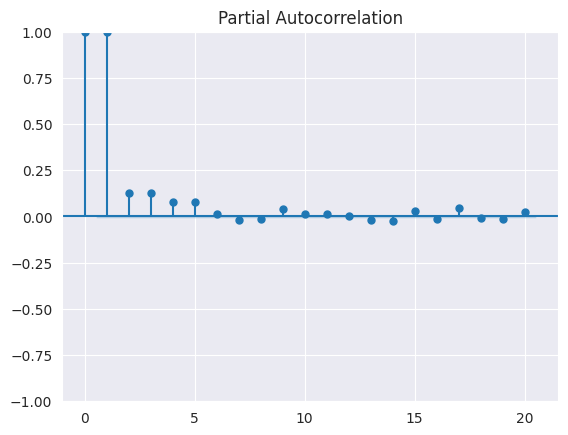

In [ ]:
plot_pacf(yPred, lags = 20)
plt.show()